In [1]:
# standard imports
import sys
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh

# projection based functions
from utilities.projection import isentropic_projection, isentropic_control_projection

# problem defining operators
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product, curl

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

# Setting Custom Problem

In [3]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Parameter List

In [72]:
# PROBLEM CONSTANTS
n = mesh.n                  # number of nodes
N = mesh.N                  # number of cells
T = 220                     # number of snapshots
nu = 1.716e-5               # kinematic viscosity
mach = 0.6                  # mach number
sos = 340.29                # isentropic speed of sound
uInfty = mach * sos         # freestream velocity
Re = 100                    # Reynolds number of freeflow
dt = 0.0001                 # simulation time step
subsampling = 6             # subsampling for data
nondim = False              # nondimensionalization of results

# POD PARAMETERS
maxPOD = 12                 # maximum number of POD modes
alpha = 1                   # inner product coefficient [(gamma - 1)/2 -> standard, 1 -> stagnation enthalpy]
gamma = 1.4                 # isentropic coefficient -> material property
include_avg = False         # include average flow in POD computation

# GALERKIN PARAMETERS
stabilization = "viscosity" # stabilization method for galerkin system
epsilon = 1e-4              # weight for sobolev norm stabilization -> experimental
if mach == 0.6:
    dt_ref = 0.0001 * subsampling     # snapshot equaivalent time step
    dt = 0.0005                       # galerkin time step
    shed_period = 0.0327              # hypothesized shed period
elif mach == 0.1:
    dt_ref = 0.001 * subsampling
    dt = 0.001
    shed_period = 0.18
elif mach == 0.01:
    dt_ref = 0.02 * subsampling
    dt = 0.02
    shed_period = 1.84
t0 = 0
tmax = shed_period * 10
temporalSpan = np.linspace(t0,tmax,int(tmax/dt)+1)
# OPTIMIZATION PARAMETERS




# Data Preparation

In [5]:
# reading file data
dataDir  = "./flow_data/lam_cyl_comp_air/mach 0.6/"
dataDict = read_csv_data(dataDir,delay=0,subsampling=subsampling,max_size=T)

# geometric information
x = dataDict["x"][:,0] - 0.5
y = dataDict["y"][:,0]

# fluid velocity and mach number
u = np.divide(dataDict['Momentum_x'], dataDict['Density'])
v = np.divide(dataDict['Momentum_y'], dataDict['Density'])
a = dataDict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
qAvg = np.mean(q,1)
qFluc = q - np.repeat(np.expand_dims(qAvg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    podData = q
else:
    podData = qFluc

### set scalar weights for multiplicative computation
# volume participations
volumeWeight = mesh.volume_weights
# additional weight for speed of sound
machWeight = (2 * alpha / (gamma - 1))
# construction of weights
innerWeight = np.concatenate([np.ones(n),np.ones(n),machWeight*np.ones(n)]) * volumeWeight

100%|██████████| 220/220 [01:07<00:00,  3.24it/s]


In [ ]:
def skalar_product(q1,q2,weights=innerWeight):
    return np.sum(q1*q2*weights)

# POD Decomposition

In [6]:
[podModes, S] = get_POD(podData,skalar_product,20)
coeffs = get_activations(podData,podModes,skalar_product,20)
if nondim:
    coeffs /= uInfty

In [7]:
# energy reconstruction threshold
epsilon = 0.99
acc = 0
dim = 0
while acc < epsilon:
    dim+=1
    acc = sum(S[:dim])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(dim))
if dim % 2 == 1:
    dim+=1

# manual value assignement
dim = 6

Number of eigenvectors necessary for thresholded reconstruction: 	4


In [8]:
# plot_activations(coeffs,dim,dt=dt*subsampling)

# Control Data Input

In [10]:
controlDir  = "./flow_data/lam_cyl_comp_air/potVortex_0.6_1/"
controlDict = read_csv_data(controlDir,0,1,1)

uCon = np.divide(controlDict['Momentum_x'], controlDict['Density'])
vCon = np.divide(controlDict['Momentum_y'], controlDict['Density'])
aCon = controlDict['Mach']

# construct state based data
qCon = np.vstack([uCon,vCon,aCon]).squeeze()

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


# Galerkin Coefficients

In [44]:
[b1, b2, L1, L2, Q] = isentropic_projection(mesh,podModes[:,:dim],qAvg,skalar_product)


100%|██████████| 6/6 [00:00<00:00, 133.35it/s]

Projection based Galerkin coefficients in order: b1,b2,L1,L2,Q


# Control Function Method
Additional coefficients in Galerkin system

In [47]:
controlList = isentropic_control_projection(mesh,podModes[:,:dim],qAvg,qCon,skalar_product)

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

Additional projection based Galerkin coefficients for control in order: d1, d2, f, g, h


# Galerkin System

In [67]:
# initial conditions
a0 = coeffs[:dim,0]

# dynamic viscosity for stabilization
if stabilization=="viscosity":
    if mach == 0.6:
        # tuned
        if dim == 10:
            nu = 4.09   # 10 modes
        elif dim == 8:
            nu = 3.24   # 8 modes
        elif dim == 6:
            nu = 3.07   # 6 modes
        elif dim == 4:
            nu = 3.625  # 4 modes
        elif dim == 2:  
            nu = 4.36   # 2 modes

    elif mach == 0.1:
        # tuned
        if dim == 10:
            nu = 0.745   # 10 modes
        elif dim == 8:
            nu = 0.7445  # 8 modes
        elif dim == 6:
            nu = 0.7390  # 6 modes
        elif dim == 4:
            nu = 0.7635  # 4 modes
        elif dim == 2:  
            nu = 0.8625  # 2 modes

    elif mach == 0.01:
        # tuned
        if dim == 10:
            nu = 0.1535  # 10 modes
        elif dim == 8:
            nu = 0.151   # 8 modes
        elif dim == 6:
            nu = 0.1515  # 6 modes
        elif dim == 4:
            nu = 0.1515  # 4 modes
        elif dim == 2:  
            nu = 0.1550  # 2 modes

In [124]:
# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1))) 
    return a_dot

In [125]:
sol = solve_ivp(galerkin_system,(t0,tmax),a0, method='LSODA',t_eval=temporalSpan)
sol.message

'The solver successfully reached the end of the integration interval.'

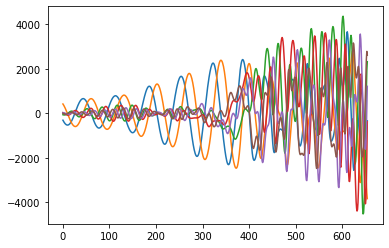

In [126]:
for i in range(6):
    plt.plot(sol.y[i,:])

# Controltheory -> Stability of the System

In [128]:
# Lyapunov Linearization -> Jacobian at equilibrium 
jacobian = np.zeros((dim,dim))
equilibrium = np.zeros(dim)
for k in range(dim):
    for i in range(dim):
        jacobian[k][i] = (nu * L1[k,i] + L2[k,i]) * equilibrium[i] + 0.5 * np.inner(Q[k][i,:],equilibrium) 




# Comparison of Limit Cycles

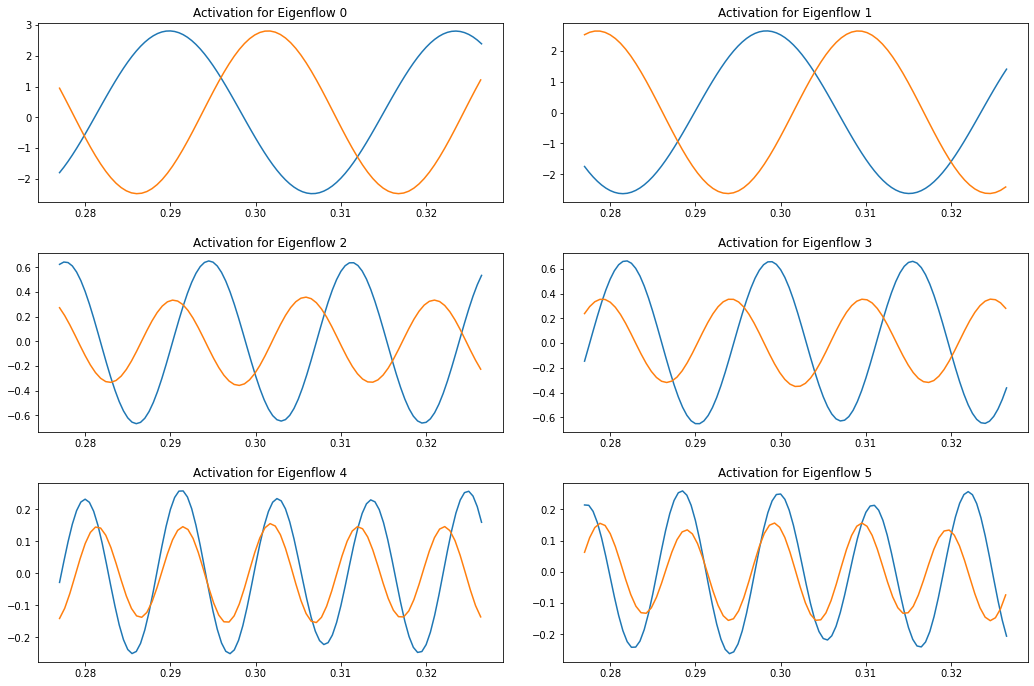

In [70]:
# Galerkin model 
d = int(dim/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span 
phase_shift = 94
plot_time_span = 100 * dt
orig_number = int(plot_time_span / (dt_ref )) #*1.09))
t_orig = np.linspace(sampling_span[-100],tmax-dt_ref,num=orig_number)

# add plots over full time domain
for i in range(dim):
    if dim <= 2:
        ax[int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i/2)][int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))